## Imports de bibliothèques python

In [109]:
# Imports
import os
working_dir = os.getcwd()

import h5py

# Personal toolboxes
import sys
sys.path.insert(1,'C:/Users/matt-/Documents/python/array_processing/toolboxes/')
sys.path.insert(1, 'E:/stagiaires/augustin/')

from utils_plot import * 
from utils_SHanalysis import *
from utils_geometry import * 
from utils_acoustics import *
from theory_spherical_cap import *

import numpy as np


# Plots 
import matplotlib.pyplot as plt
%matplotlib widget

## Quelques fonctions utiles pour la suite

In [110]:
def plot_SHspectra(N_SH_axis, SHcoefs_list, ind_k, fig = None, SHcoefs_th = np.array([]), NCC_list = []):
    legend = ['New center', 'Initial']
    if fig == None:
        fig = plt.figure()
    ax_amp = None
    ax_phase = None
    N_method = len(SHcoefs_list)
    for ind_method in range(N_method):
        ax_amp = fig.add_subplot(2,N_method, ind_method + 1, sharex = ax_amp, sharey = ax_amp)
        ax_amp.scatter(N_SH_axis, np.abs(SHcoefs_list[ind_method][:, ind_k]))
        
        # ax_amp.set_title('Method %d'%ind_method)
        ax_amp.set_ylabel('Amplitude')

        ax_phase = fig.add_subplot(2,N_method, ind_method + N_method + 1, sharex = ax_amp, sharey = ax_phase)
        ax_phase.scatter(N_SH_axis, np.angle(SHcoefs_list[ind_method][:, ind_k]))
        ax_phase.set_xlabel('SH order')
        ax_phase.set_ylabel('Phase (radian)')

        if SHcoefs_th.shape[0] != 0:
            if len(NCC_list)!=0:
                ax_amp.set_title('Method %d \n, NCC = %.3f'%(ind_method+1,NCC_list[ind_method][ind_k]))
            ax_amp.scatter(N_SH_axis, np.abs(SHcoefs_th[:,ind_k]), marker = 'x', color = 'r')
            ax_phase.scatter(N_SH_axis, np.angle(SHcoefs_th[:, ind_k]), marker = 'x', color = 'r')
            ampmax = np.max(SHcoefs_list[ind_method][:, ind_k])
            ax_amp.set_ylim([-0.1*ampmax, ampmax*1.1])
            ax_phase.set_ylim([-np.pi, np.pi])
    plt.tight_layout()
    

def plot_dirballoons(Dinf_list, ind_k,elev = 30, azim = -60, rot= 0, nbtheta_look = 51, nbphi_look = 103,  fig = None, scale = 'dB', dynamic_range = 20, step = 5, legend = '', phase = True):

    N_method = len(Dinf_list)

    if fig == None:
        plt.figure()

    points = np.arange(-dynamic_range, dynamic_range+step, step)

    for ind_method in range(N_method):

        ax = fig.add_subplot(N_method, 1 ,ind_method + 1, projection='3d')
        draw_directivity_balloon(Dinf_list[ind_method][:,ind_k], nbtheta=nbtheta_look, nbphi = nbphi_look, scale = scale, dynamic_range=dynamic_range, ref_sphere= False, ax = ax, phase = phase)
        for point in points :
            ax.text(point, 0, 0, str(np.abs(point)))
            ax.text(0, point, 0, str(np.abs(point)))
            ax.text(0, 0, point, str(np.abs(point)))
        ax.text(30, 0, 0, 'z+')
        ax.text(-30, 0, 0, 'z-')
        
        ax.text(0, 30, 0, 'y-')
        ax.text(0, -30, 0, 'y+')
        ax.text(0, 0, 30, 'x+')
        ax.text(0, 0, -30, 'x-')
        ax.stem3D(points, np.zeros_like(points), np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), points, np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), np.zeros_like(points), points, linefmt = 'C1:', markerfmt = 'C0:')
        ax.view_init(elev, azim, rot)
        ax.set_axis_off()
        if legend == '' : 
            ax.set_title('Method %d'%ind_method)
        else :
            ax.set_title(legend[ind_method])
            
        plt.tight_layout()

def dB(x) :
    return 20*np.log10(np.abs(x)/np.max(np.abs(x)))

def Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N = 9, nbtheta_look = 51, nbphi_look = 103, lambda_reg = 1e-4) :
    kvect = 2*np.pi*freqvect/c0
    N_SH_vect = compute_N_SH_vect(freqvect, N, rmin = 1.5)
    H_array = compute_SphericalWavesbasis_origin_to_field(XYZ_Mems, kvect, N)
    cmn = compute_SHcoefs(x_meas, H_array, N_SH_vect = N_SH_vect, lambda_reg=lambda_reg)
    angles_look = create_equal_angle_grid(nbtheta_look, nbphi_look)
    Dinf_meas = compute_Dinf_from_SH_coefs_at_origin(cmn,angles_look, kvect)

    return(cmn, Dinf_meas)

def smooth_hammer(ref) :
    mult_50 = np.arange(10,5001,10)

    hammer_smoothed = np.abs(ref)
    for i in mult_50[:-1] :
        hammer_smoothed[i] = np.mean((hammer_smoothed[i-1], hammer_smoothed[i+1]))
    hammer_smoothed[-1] = hammer_smoothed[-2]

    return(hammer_smoothed)

def comp_spatial_correlation(f,g) :
    nbtheta = 51
    nbphi = 103
    N = nbtheta*nbphi
    theta = np.linspace(0,np.pi,nbtheta) # look directions, elevation (uniform distribution)
    dcostheta = np.array([np.cos(theta[i]) - np.cos(theta[i+1]) for i in range(nbtheta-1)] + [0.])
    dcostheta_on_grid = npm.repmat(dcostheta,1,nbphi).reshape(N)
    dphi = 2*np.pi/nbphi*np.ones(nbphi)
    dphi_on_grid = npm.repmat(dphi,nbtheta,1).transpose().reshape(N)
    weights = (dcostheta_on_grid*dphi_on_grid)
    sum_f = f.T*weights@np.conj(f)
    sum_g = g.T*weights@np.conj(g)
    sum_fg = f.T*weights@np.conj(g)
    return (sum_fg / np.sqrt( sum_f * sum_g ))

def hammer_spectre(time_signal) :
    i = 30
    n = len(time_signal)
    argmax = np.argmax(time_signal)
    impact = time_signal[argmax-i//2:argmax+i*3//2]
    return np.abs(np.fft.rfft(impact, n = n))

def normalize_signal(signal, hammer, ind_freq_study) :
    ref = hammer_spectre(hammer)[ind_freq_study]
    return signal/ref

## Position des micros

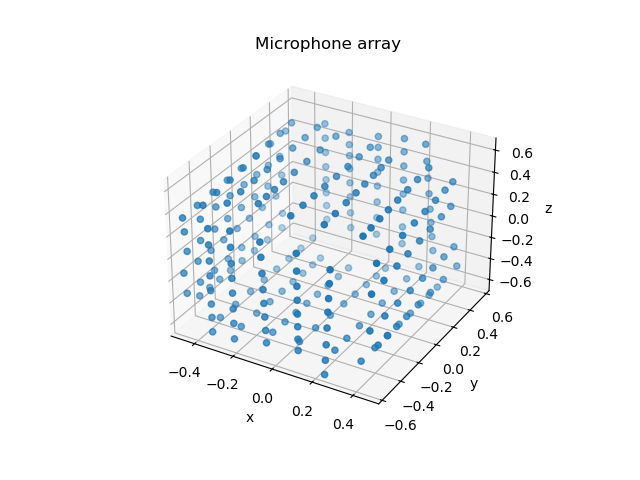

In [111]:
array_file = 'E:/experiments/data/antenne256_05_23/calib_geo/XYZm_Calib3_aligne.npz'
XYZ = np.load(array_file)['XYZm'][:-1,:] 

rot_angle = np.pi/2
Ry = np.array([[np.cos(rot_angle),0,np.sin(rot_angle)],[0,1,0],[-np.sin(rot_angle),0,np.cos(rot_angle)]])


# 00cm
center_source = [-11.5e-2,0,16e-2]

ind_samples = [27*8, 12*8, 0, 31*8 + 7, 28*8, 20*8+2 , 2*8, 1*8, 12*8 + 7, 29*8+4, 24*8+3]
XYZ_samples_ref = np.array([[50,30,53], 
                    [-67,-39, -21],
                    [-49, 54, 45],
                    [28,-50,-29],
                    [24, -61, 42],
                    [0,-60,-13],
                    [50,25,-22],
                    [-65,-41,53],
                    [-66,40,-5],
                    [-23,0,-29],
                    [-4,-4,60]], dtype = float)*1e-2

XYZ_ref_retrieved = XYZ[ind_samples[2],:]
XYZ_ref_real = XYZ_samples_ref[2,:]

XYZ[:,1] *=-1
XYZ_centered  = XYZ - XYZ_ref_retrieved + XYZ_ref_real

XYZ_Mems = XYZ_centered[:-1,:]-center_source
XYZ_Mems = XYZ_Mems@Ry
plot_array(XYZ_Mems)


In [112]:
reverse_z = False
if reverse_z:
    XYZ_Mems = np.vstack((XYZ_Mems[:,0],XYZ_Mems[:,1],-XYZ_Mems[:,2])).T
    center_source[2] *= -1


## Chargement des mesures

In [114]:
# Paramètres fréquentiels
# freqvect = np.array([125,250, 500, 1000, 1500, 2000, 2500, 3000]) # Hz
freqvect = np.arange(100, 5001, 10) # Hz
N_freq = len(freqvect)
c0 = 343 # m/s
kvect = 2*np.pi*freqvect/c0 


# r_array = 1.4

# # ordre de troncature pour l'analyse SH
# N_SH_max = 6
# eta = 3
# N_SH_vect = compute_N_SH_vect(freqvect, N_SH_max, rmin = r_array, eta = eta, c0 = c0) # ordre de troncature dépendant de la fréquence pour la méthode 1

import h5py

source_folder = 'E:/experiments/data/antenne256_05_23/Mu256_Anech_230517/DataCalotte_00cm/'
input_file = 'mu5h-20230517-150510.h5'


data = h5py.File(source_folder + input_file,'r') #working_dir + source_folder + input_file, 'r')  
    
Secs = [int(i) for i in data['muh5'].keys()] 
NbSecs = len(data['muh5'].keys())

Sig = np.concatenate([data['muh5'][str(i)]['sig'][:] for i in range(NbSecs)], axis=1)

fs = 50e3
Nsamples = int(NbSecs*fs)
ind_Mems_ref = 4*8+3
vectf = np.fft.rfftfreq(Nsamples, 1/fs)
ind_freq_study = []
for ind_freq in range(len(freqvect)):
    ind_freq_study.append(np.argmin(np.abs(freqvect[ind_freq] - vectf)))

Mems = Sig[1:257,:]
Ref = Sig[257:,:]
SRef = np.fft.rfft(Ref, axis = 1)
SMems = np.fft.rfft(Mems)
TF_Memsref_Memsi = SMems/SMems[ind_Mems_ref,:]
x_meas = TF_Memsref_Memsi[:,ind_freq_study]

Text(0.5, 0, 'x (m)')

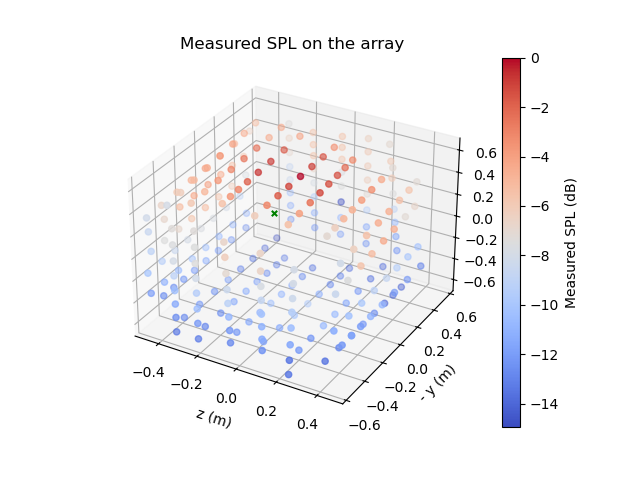

In [115]:
RMS_meas = np.sqrt(np.sum(np.abs(x_meas)**2, axis = 1))
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
plot_measurements_dB(XYZ_Mems, RMS_meas, ax = ax)
ax.scatter(center_source[0], center_source[1], center_source[2], marker = 'x', color = 'g', s = 15)
ax.set_xlabel('z (m)')
ax.set_ylabel('- y (m)')
ax.set_zlabel('x (m)')

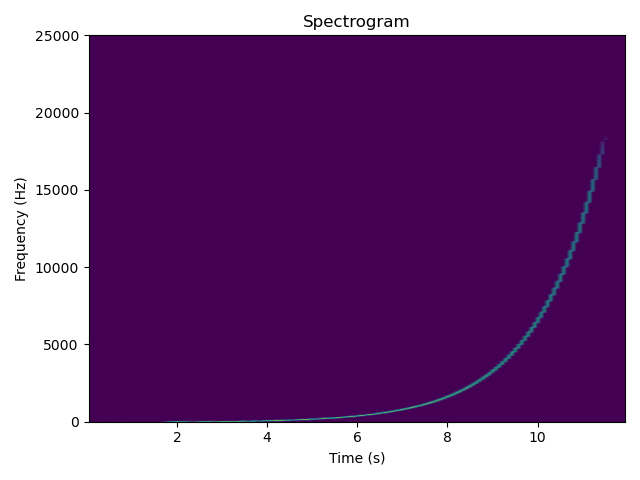

In [116]:
import scipy.signal
f_spectro, t_spectro, spectro_ref = scipy.signal.spectrogram(Ref[0], fs = fs, nperseg = 2**12)
DR = 80
spectro_ref = spectro_ref.squeeze()
spectro_ref_dB = 20*np.log10(spectro_ref/spectro_ref.max())
spectro_ref_dB[spectro_ref_dB< -DR] = -DR 
fig = plt.figure()
plt.pcolormesh(t_spectro, f_spectro, spectro_ref_dB, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
# plt.xlim([0,12])
# plt.ylim([20,5e3])
plt.tight_layout()

## Calcul de directivité

In [117]:
SH_dic = {}
Dinf_dic = {}

N_SH_test = np.arange(1,15, dtype = int)

for N in N_SH_test:
    SH_dic[N], Dinf_dic[N] = Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N=N, lambda_reg = 1e-2)

C:\Users/matt-/Documents/python/array_processing/toolboxes\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


## Directivité théorique

In [118]:
N_SH_th = 50

r_sphere = 8.5e-2
r_opening = 4e-2
theta_0 = np.arctan(r_opening/r_sphere)
rho0 = 1.293
angles_look = create_equal_angle_grid(51,103)

# compute axis-symetrical SH coefficients of the pressure at origin
SHcoefs_velocity_on_baffle = -1j*rho0*c0*comp_SHcoefs_velocity_on_baffle_piston_sphericalbaffle(kvect, r_sphere = r_sphere, r_opening = r_opening, N_SH_max = N_SH_th, Wdot = 1)
SH_orders = np.arange(N_SH_th+1, dtype = int)
SHcoefs_pressure = SHcoefs_velocity_on_baffle[:,np.newaxis]/spherical_hn_diff(SH_orders[:,np.newaxis],kvect[np.newaxis,:]*r_sphere) # SH coefs of the pressure at the origin (cmn)

# transform axis-symmetrical SH coefficients into classical SH ones
SHcoefs_th = np.zeros(((N_SH_th+1)**2, N_freq), dtype = complex)
for ind_SH in range(N_SH_th):
    alpha_n = np.sqrt(4*np.pi/(2*ind_SH+1))
    SHcoefs_th[ind_SH**2 + ind_SH,:] = SHcoefs_pressure[ind_SH,:]*alpha_n # Y_{nm}(\theta, \phi)

Dinf_th = np.array([comp_dir(f,50,angles_look[:,0], R = r_sphere, c0 = c0, rho0 = rho0, theta_0 = theta_0) for f in freqvect]).T

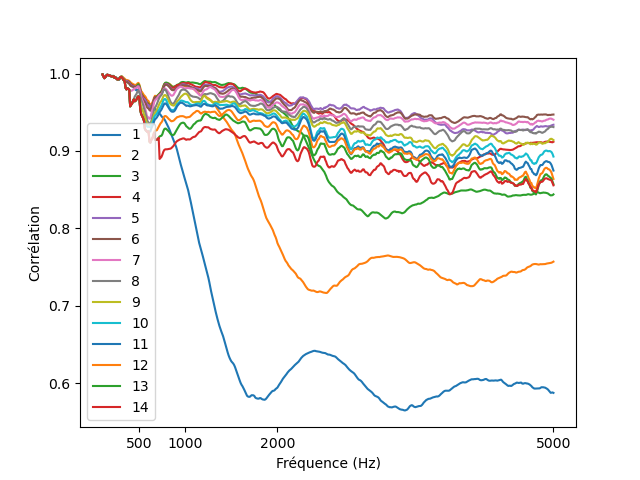

In [119]:
orientation = 'v'
if orientation == 'v' :
    plan = np.hstack((np.arange(51),np.arange(2651,2600,-1)))
    theta = np.linspace(np.pi/2,5/2*np.pi,102)
elif orientation == 'h' :
    hor = []
    for i in range(len(angles_look)) :
        if np.abs(sph2cart(angles_look))[i,2]<1e-3 : hor.append(i)
    plan = hor
    theta = np.linspace(np.pi/2,5/2*np.pi,103)
else : plan = []

fig = plt.figure()
ax = fig.add_subplot()
NCC_dict = {}
for N in N_SH_test:
    # NCC_dict[N] = compute_NCC(SHcoefs_th,SH_dic[N]) #Dinf_dic[N][plan],Dinf_th[plan])
    NCC_dict[N] = compute_NCC(Dinf_dic[N],Dinf_th)

    
    ax.plot(freqvect,NCC_dict[N].T)
    ax.set_xlabel('Fréquence (Hz)')
    ax.set_ylabel('Corrélation')
    ticks = [500,1000,2000,5000]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
# ax.set_xticks([100,200,300,400,500,700,1000,1500])
# ax.set_xticklabels([100,200,300,400,500,700,1000,1500])
# ax.set_xlim([200,700])
plt.legend(N_SH_test)

Text(0, 0.5, 'Corrélation')

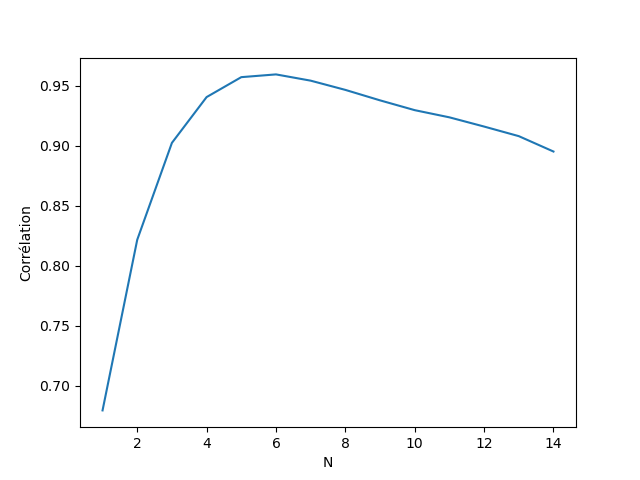

In [120]:
NCC_avg = []

for N in N_SH_test:
    NCC_avg.append(np.mean(NCC_dict[N]))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_SH_test,NCC_avg)
ax.set_xlabel('N')
ax.set_ylabel('Corrélation')
# ticks = [500,1000,2000,5000]
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticks)

In [121]:
SH_dic[N].shape
SHcoefs_th.shape

(2601, 491)

### Comparaison entre théorie et reconstruction des spectres SH

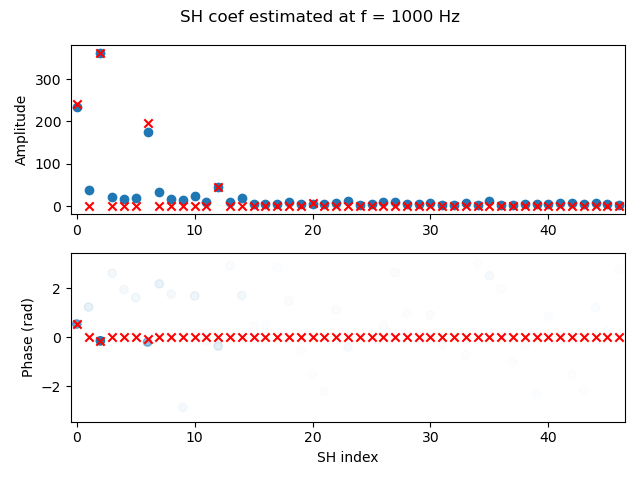

In [122]:
N_SH_max = 6
cmn = SH_dic[N_SH_max]
# Analyse des résultats
SH_axis = np.arange((N_SH_max+1)**2, dtype = float)
SH_axis_th = np.arange((N_SH_th+1)**2, dtype = float)

f = 1000
ind_k = np.argmin(np.abs(f-freqvect))

NCC = compute_NCC(SHcoefs_th, cmn)
ind_max_SH = np.argmax(np.abs(SHcoefs_th[:,ind_k]))
SHcoefs_exp = cmn[:,ind_k] * SHcoefs_th[ind_max_SH,ind_k] / cmn[ind_max_SH,ind_k]


fig = plt.figure()
ax_amp = fig.add_subplot(211)
ax_phase = fig.add_subplot(212, sharex = ax_amp)
phase_shading_vect = np.trunc(100*np.abs(SHcoefs_exp/np.max(np.abs(SHcoefs_exp))))/100
ax_amp.scatter(SH_axis, np.abs(SHcoefs_exp))
ax_amp.scatter(SH_axis_th, np.abs(SHcoefs_th[:,ind_k]), marker = 'x', color = 'r')
ax_phase.scatter(SH_axis, np.angle(SHcoefs_exp), alpha = phase_shading_vect)
ax_phase.scatter(SH_axis_th, np.angle(SHcoefs_th[:,ind_k]), marker = 'x', color = 'r')

fig.suptitle('SH coef estimated at f = %.0f Hz'%(freqvect[ind_k]))
ax_amp.set_ylabel('Amplitude')
ax_phase.set_ylabel('Phase (rad)')
ax_phase.set_xlabel('SH index')
ax_amp.set_xlim([-0.5,46.5])
plt.tight_layout()


In [123]:
SHcoefs_th.shape

(2601, 491)

In [124]:
D_plot = [Dinf_dic[6], Dinf_th] #[Dinf_00_1, Dinf_00_2,Dinf_10,Dinf_26] 

In [125]:
# plt.figure()
# plt.plot(N_SH_test,NCC_dict)
# # plt.xticks(N)
# plt.ylabel('NCC')
# plt.xlabel('Ordre N maximal')

In [126]:
NCC_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

### Comparaison entre théorie et estimation de directivité

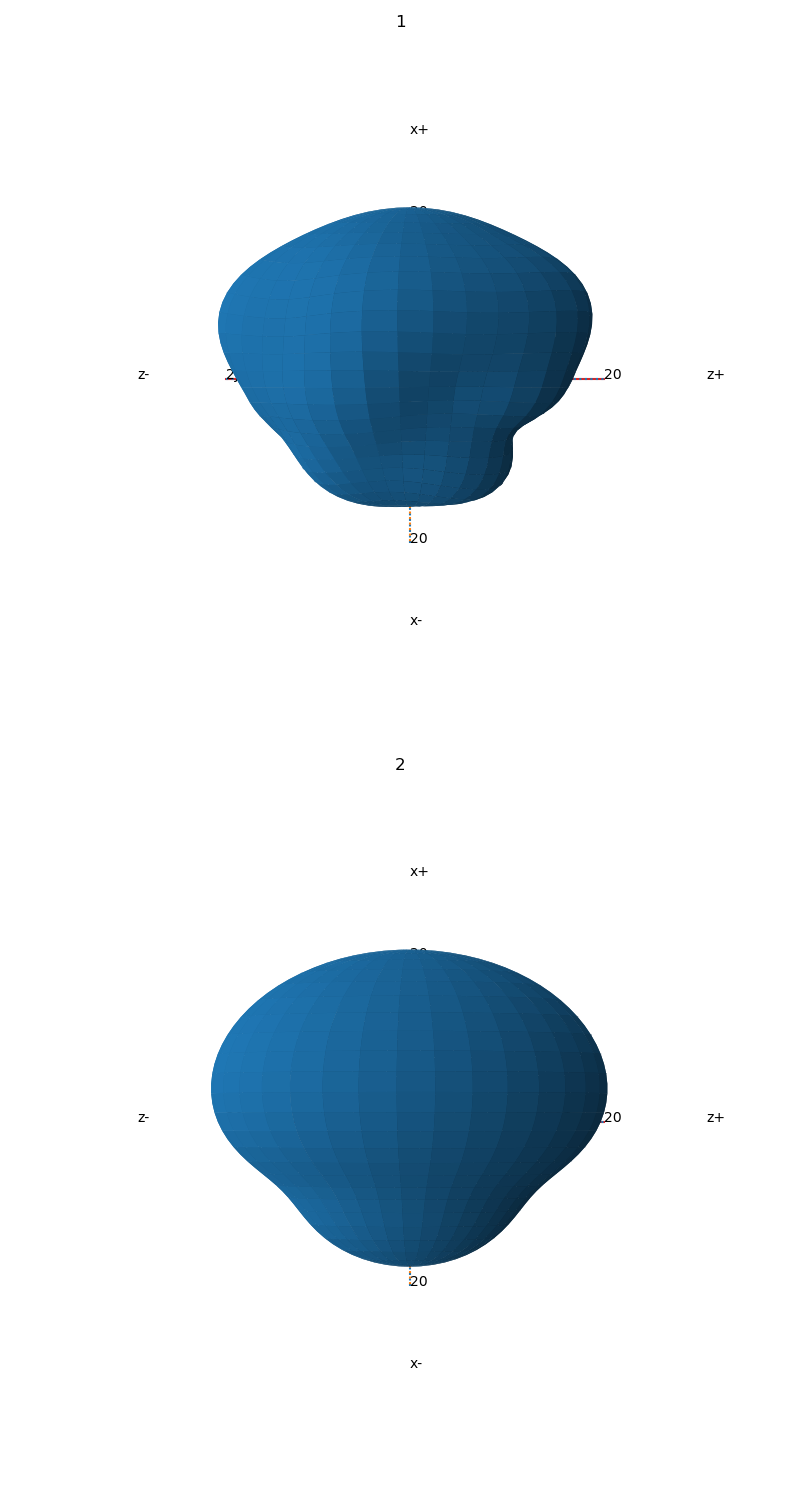

In [127]:
fig = plt.figure(figsize = (8,15))
# fig.suptitle(f'Directivity estimation results at {freqvect[ind_k]} Hz \n Correlation = {np.round(NCC[ind_k],3)}')
plot_dirballoons(D_plot, ind_k, elev=0,fig = fig, legend = [1,2,3,4],phase = False)

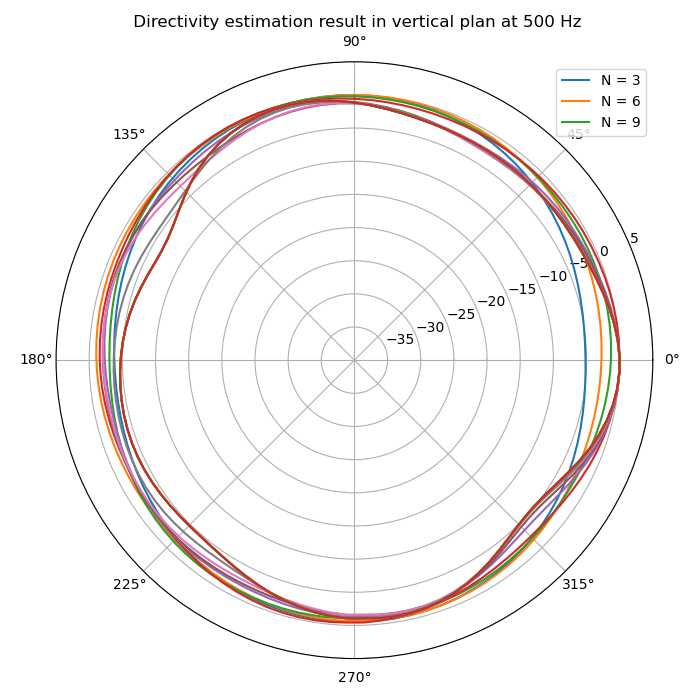

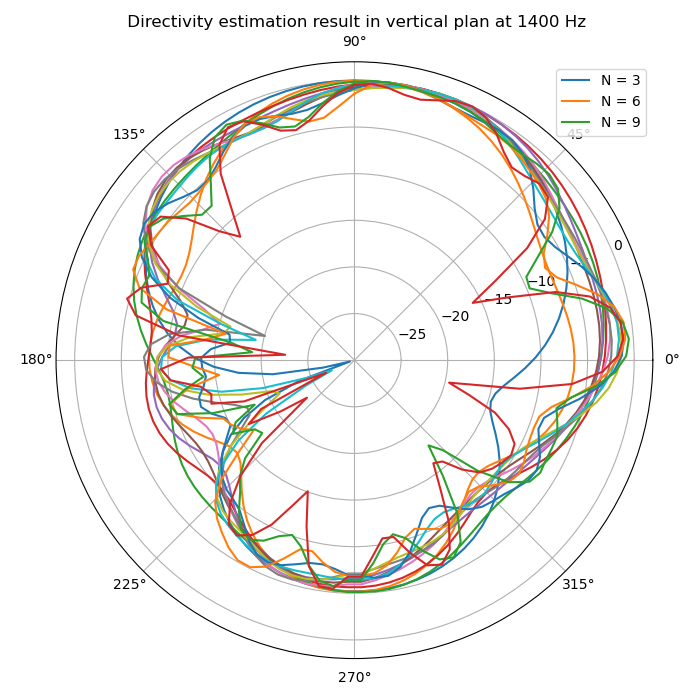

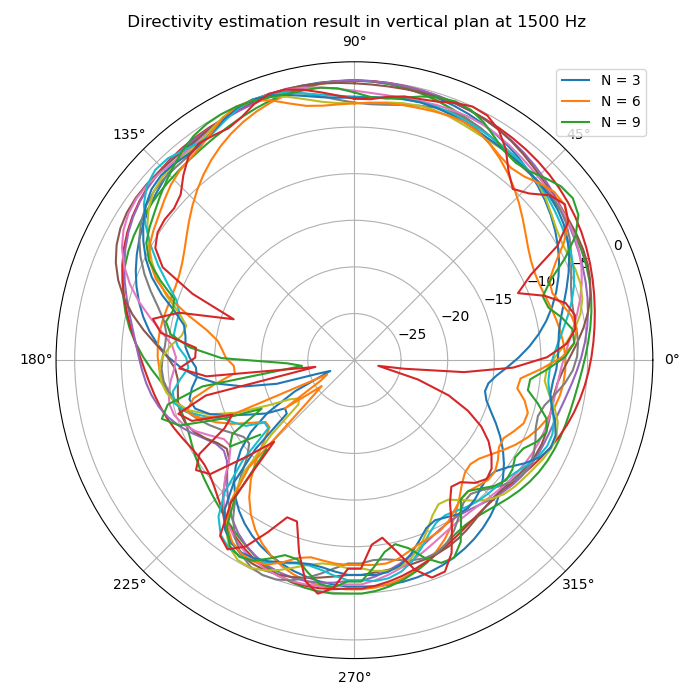

In [128]:
angles_look = create_equal_angle_grid(51,103)

orientation = 'v'

freqplot = [500,1400,1500]

if orientation == 'v' :
    plan = np.hstack((np.arange(51),np.arange(2651,2600,-1)))
    theta = np.linspace(np.pi/2,5/2*np.pi,102)
elif orientation == 'h' :
    hor = []
    for i in range(len(angles_look)) :
        if np.abs(sph2cart(angles_look))[i,2]<1e-3 : hor.append(i)
    plan = hor
    theta = np.linspace(np.pi/2,5/2*np.pi,103)
else : plan = []

# weights_circular = np.hstack((np.diff(theta),0))

# circular_correlation = compute_normalized_circular_correlation(Dinf_th[plan], Dinf_meas[plan], weights = weights_circular)


for f in freqplot :
    ind_f = np.argmin(np.abs(f-freqvect))
    fig = plt.figure(figsize= (7,7))
    ax = fig.add_subplot(1, 1, 1, projection = 'polar')
    for Dinf in Dinf_dic.values() :
        ax.plot(theta, dB(Dinf[plan,ind_f]))
    # ax.plot(theta, dB(Dinf_th[plan,ind_f]))
    ax.legend(['N = 3','N = 6','N = 9'])
    # ax.legend(['z = 15cm (1)','z = 15cm (2)','z = 25cm','z = 41cm','theorie'])
    # ax.set_title(f" f = {f} Hz \n correlation = {round(circular_correlation[ind_f], 3)} \n JSI = {round(JSI[ind_f], 3)}")
    ax.set_title(f" Directivity estimation result in vertical plan at {f} Hz")

    if f>1000 : (rmin,rmax) = (-30,2)
    else : (rmin, rmax) = (-40, 5)
    ax.set_rmax(rmax)
    # ax.set_rmin(dynamique[ind])
    ax.set_rmin(rmin)
    plt.tight_layout()

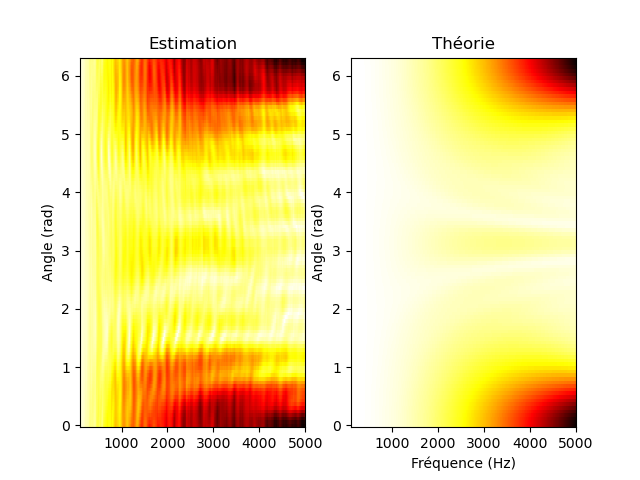

In [129]:
title = ['z = 15cm (1)','z = 15cm (2)','z = 25cm','z = 41cm','theorie']

# fig = plt.figure(figsize=(8,7))
# for i,Dinf in enumerate(D_plot) :
#     ax  = fig.add_subplot(2,2,i+1)
#     colorplot = np.abs(Dinf[plan])
#     cs = ax.pcolor(freqvect,theta,colorplot, cmap = 'hot_r')
#     ax.set_title(title[i])
#     if i>1 : ax.set_xlabel('Frequency (Hz)')
#     if i%2 == 0 : ax.set_ylabel('Angle (rad)')
#     fig.colorbar(cs, ax=ax)
fig, ax = plt.subplots(1,2)
colorplot = np.abs(Dinf_dic[6][plan])
cs = ax[0].pcolor(freqvect,theta-np.pi/2,colorplot, cmap = 'hot_r')
ax[0].set_title('Estimation')
ax[0].set_ylabel('Angle (rad)')
colorplot = np.abs(Dinf_th[plan])
ax[1].set_title('Théorie')
ax[1].set_ylabel('Angle (rad)')
ax[1].set_xlabel('Fréquence (Hz)')
cs = ax[1].pcolor(freqvect,theta-np.pi/2,colorplot, cmap = 'hot_r')

## Intercorrélation spatiale


Text(0.5, 0, 'x')

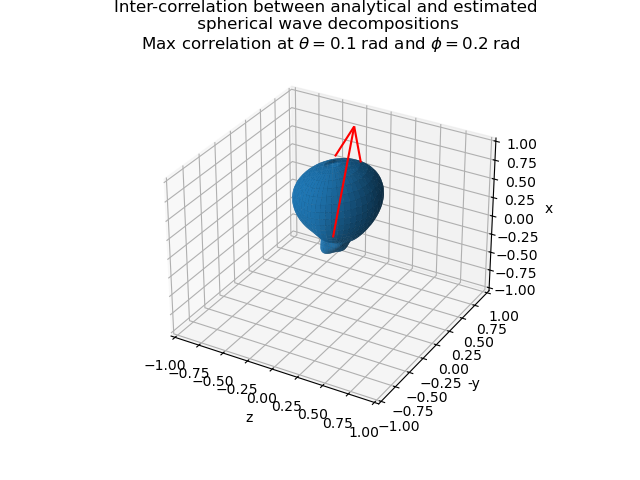

In [141]:
corr_SH = SHcoefs_exp * np.conjugate(SHcoefs_th[ind_k,(N_SH_max+1)**2])

nbtheta_corr = 201
nbphi_corr = 403
angles_look = create_equal_angle_grid(nbtheta = nbtheta_corr, nbphi = nbphi_corr)
H = compute_SphericalHarmonics_matrix(angles_look, N_SH_max)
H.shape

R_space = H @ corr_SH
ind_maxcorr = np.argmax(np.abs(R_space))
angles_maxcorr = angles_look[ind_maxcorr,:]
theta_maxcorr = angles_maxcorr[0]
phi_maxcorr = angles_maxcorr[1]
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
draw_directivity_balloon(R_space, angular_grid = np.array([]), nbtheta = nbtheta_corr, nbphi = nbphi_corr, fig = None, ax = ax, scale = 'linear', dynamic_range = 10, ref_sphere  = False, phase = False)
quiver_scale = 1.5
ax.quiver(0,0,0, quiver_scale*np.sin(theta_maxcorr)*np.cos(phi_maxcorr), quiver_scale*np.sin(theta_maxcorr)*np.sin(phi_maxcorr),quiver_scale*np.cos(theta_maxcorr), color = 'r') #, scale = 2)
ax.set_title('Inter-correlation between analytical and estimated \n spherical wave decompositions \n Max correlation at '+ r'$\theta = %.1f$ rad and $\phi = %.1f$ rad'%(angles_maxcorr[0],angles_maxcorr[1]))
ax.set_xlabel('z')
ax.set_ylabel('-y')
ax.set_zlabel('x')